In [1]:
import os
import sys
import pandas as pd
import yaml 
from matplotlib import pyplot as plt

with open("../../config.yaml.local", "r") as f:
    LOCAL_CONFIG = yaml.safe_load(f)
with open("../../config.yaml", "r") as f:
    CONFIG = yaml.safe_load(f)
sys.path.append("../python")

import globals

RAW_DATA_PATH = LOCAL_CONFIG["RAW_DATA_PATH"]


In [52]:
users_df = pd.read_parquet(os.path.join(RAW_DATA_PATH, "users.parquet"))
item_df = pd.read_parquet(os.path.join(RAW_DATA_PATH, "item.parquet"))
itemact_df = pd.read_parquet(os.path.join(RAW_DATA_PATH, "itemact.parquet"))
invoice_df = pd.read_parquet(os.path.join(RAW_DATA_PATH, "invoice.parquet"))
withdrawal_df = pd.read_parquet(os.path.join(RAW_DATA_PATH, "withdrawal.parquet"))
invoiceforward_df = pd.read_parquet(os.path.join(RAW_DATA_PATH, "invoiceforward.parquet"))
wallet_df = pd.read_parquet(os.path.join(RAW_DATA_PATH, "wallet.parquet"))
walletprotocol_df = pd.read_parquet(os.path.join(RAW_DATA_PATH, "walletprotocol.parquet"))


In [54]:
walletprotocol_df.head(5)

,id,created_at,updated_at,config,walletId,send,name,enabled,status
0,3171,2025-08-03 23:25:04.319,2025-10-05 18:49:19.344,None,2261,False,LN_ADDR,True,WARNING
1,3218,2025-08-07 00:05:34.318,2025-08-07 00:33:41.383,None,2293,True,WEBLN,True,ERROR
2,618,2025-07-16 11:31:13.754,2025-10-05 18:49:19.344,None,664,False,LN_ADDR,True,OK
3,1394,2025-07-16 11:31:13.754,2025-10-05 18:49:19.344,None,1030,False,LN_ADDR,True,OK
4,228,2025-07-16 11:31:13.754,2025-10-05 18:49:19.344,None,1573,False,LN_ADDR,True,OK


In [59]:
withdrawal_df.columns

Index(['id', 'created_at', 'updated_at', 'userId', 'hash', 'bolt11',
       'msatsPaying', 'msatsPaid', 'msatsFeePaying', 'msatsFeePaid', 'status',
       'autoWithdraw', 'protocolId', 'preimage'],
      dtype='object')

In [15]:
withdrawal_df['bolt11'].isnull().value_counts()

bolt11
True    588462
Name: count, dtype: int64

In [6]:
invoiceforward_df.columns

Index(['id', 'created_at', 'updated_at', 'bolt11', 'maxFeeMsats', 'protocolId',
       'expiryHeight', 'acceptHeight', 'invoiceId', 'withdrawlId'],
      dtype='object')

In [41]:
# summary
n_users = len(users_df)
n_items = len(item_df)
first_date = item_df['created_at'].min().strftime('%Y-%m-%d')
last_date = item_df['created_at'].max().strftime('%Y-%m-%d')
print(f"{n_users:,.0f} users, {n_items:,.0f} items from {first_date} to {last_date}")

30,737 users, 1,240,214 items from 2021-06-11 to 2025-10-05


In [ ]:
# Receive wallet attach date
# minimum of first autowithdraw date and first wallet create date

# first autowithdraw date
idx = (withdrawal_df['autoWithdraw']==True) & (withdrawal_df['status']=='CONFIRMED')
autowithdraw_df = withdrawal_df.loc[idx].groupby('userId').agg(
    first_auto_withdraw = ('created_at', 'min')
).reset_index()

# first wallet create date
wallet_create_df = wallet_df.groupby('userId').agg(
    first_wallet_create = ('created_at', 'min')
).reset_index()

attach_df = wallet_create_df.merge(autowithdraw_df, on='userId', how='outer')

attach_df['attach_date'] = attach_df[['first_wallet_create', 'first_auto_withdraw']].min(axis=1)


attach_date
False    2298
Name: count, dtype: int64

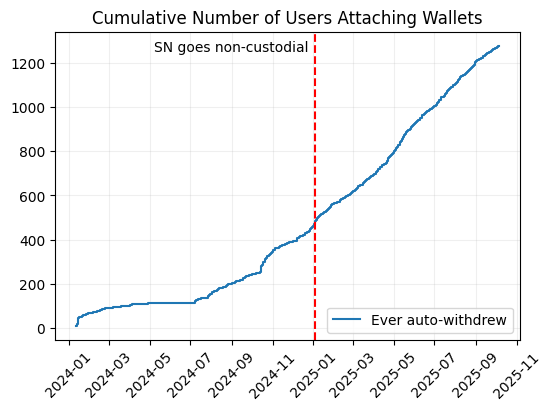

In [69]:
# plot cumulative wallet attaches

plot_df = attach_df['first_auto_withdraw'].dt.date.value_counts().sort_index().cumsum()

plt.figure(figsize=(6,4))
plt.step(plot_df.index, plot_df.values, where='post', label='Ever auto-withdrew')
plt.axvline(globals.nc_date, color='red', linestyle='--')
plt.text(globals.nc_date - pd.to_timedelta(10,unit='D'), 1250, 'SN goes non-custodial', ha='right')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.title("Cumulative Number of Users Attaching Wallets")
plt.grid(alpha=0.2)
plt.show()